In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras import layers
from tensorflow.keras import backend as K

*Cargar Dataset y preparar el dataset*

In [2]:
dataset = pd.read_excel('bike_train.xlsx')

In [3]:
dataset.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [4]:
dataset['day']=pd.DatetimeIndex(dataset['dteday']).day
dataset['month']=pd.DatetimeIndex(dataset['dteday']).month
dataset['year']=pd.DatetimeIndex(dataset['dteday']).year

In [5]:
#sacamos aquellas columnas que no son útiles para calcular el cnt
dataset.drop(columns = ['instant','dteday','mnth','casual','registered'], inplace=True)

In [6]:
#dividimos el dataset en entrenamiento y test, para el test simplesmente sacamos todo aquello que sea entrenamiento
train_dataset = dataset.sample(frac=0.8,random_state=42)
test_dataset = dataset.drop(train_dataset.index)

In [7]:
# Normalización
# creamos variables con los valores del describe() del dataset, que nos permitirá realizar una normalizacion en base a la media y desviación estandar
# así los datos serán relativos y no absolutos
train_stats = train_dataset.describe()
train_stats.pop("cnt")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
season,9599.0,2.206063,1.087274,1.00,1.0000,2.0000,3.0000,4.0000
yr,9599.0,0.277737,0.447906,0.00,0.0000,0.0000,1.0000,1.0000
hr,9599.0,11.606834,6.901898,0.00,6.0000,12.0000,18.0000,23.0000
holiday,9599.0,0.028961,0.167707,0.00,0.0000,0.0000,0.0000,1.0000
weekday,9599.0,3.018023,2.000778,0.00,1.0000,3.0000,5.0000,6.0000
workingday,9599.0,0.686217,0.464053,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,9599.0,1.437337,0.650233,1.00,1.0000,1.0000,2.0000,4.0000
temp,9599.0,0.466313,0.188624,0.02,0.3200,0.4600,0.6200,0.9600
atemp,9599.0,0.449532,0.169553,0.00,0.3030,0.4545,0.5909,1.0000
hum,9599.0,0.625166,0.200811,0.00,0.4700,0.6200,0.7900,1.0000


In [8]:
#separamos las features de entrenamiento
train_labels = train_dataset.pop('cnt')
test_labels = test_dataset.pop('cnt')

In [9]:
# normalizacion por medio de la standarizacion
def norm(x):
    return (x - train_stats['mean'])/train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [10]:
normed_train_data.head(3)

,season,yr,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,day,month,year
1935,-0.189523,-0.620079,-0.232810,-0.172691,1.490409,-1.478746,-0.672586,-1.093778,-1.131988,-1.071486,-0.253872,1.212388,-0.734666,-0.620079
6494,1.649941,-0.620079,-1.102137,-0.172691,-1.008619,0.676178,-0.672586,-0.669655,-0.595873,1.219225,-0.728461,-1.420708,1.304511,-0.620079
1720,-1.109255,-0.620079,-0.522586,-0.172691,0.490798,0.676178,-0.672586,-0.563624,-0.595873,0.173466,-0.491564,0.182046,-0.734666,-0.620079


*MODELO*

In [13]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [14]:
def build_model():
    model = keras.Sequential([
        layers.Dense(32 , activation='relu',input_shape=[len(train_dataset.keys())]),
        layers.Dense(32, activation='relu'),
        layers.Dense(1,kernel_constraint=tf.keras.constraints.NonNeg())
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss=root_mean_squared_error,optimizer=optimizer,metrics=[root_mean_squared_error,'mae','mse'])

    return model

In [15]:
model = build_model()

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                480       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,569
Trainable params: 1,569
Non-trainable params: 0
_________________________________________________________________


*Entrenamiento*

In [17]:
train_labels = pd.to_numeric(train_labels, errors='coerce',downcast='float')
train_labels

1935     125.0
6494       8.0
1720     299.0
9120      72.0
360      104.0
         ...  
5439     232.0
11085      4.0
8964      81.0
11660    121.0
5510     207.0
Name: cnt, Length: 9599, dtype: float32

In [18]:
EPOCHS = 500

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS,validation_split = 0.2, verbose = 0,
    callbacks=[tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:192.1958,  mae:136.0510,  mse:38257.5078,  root_mean_squared_error:192.1841,  val_loss:159.8983,  val_mae:108.8665,  val_mse:26721.4297,  val_root_mean_squared_error:159.8983,  
....................................................................................................
Epoch: 100, loss:111.0624,  mae:81.9301,  mse:12750.0859,  root_mean_squared_error:111.0639,  val_loss:118.5267,  val_mae:87.0416,  val_mse:14538.3340,  val_root_mean_squared_error:118.5267,  
....................................................................................................
Epoch: 200, loss:74.6765,  mae:50.7756,  mse:5954.2939,  root_mean_squared_error:74.6744,  val_loss:82.5746,  val_mae:55.2462,  val_mse:7256.0708,  val_root_mean_squared_error:82.5746,  
....................................................................................................
Epoch: 300, loss:46.2288,  mae:31.5740,  mse:2251.9041,  root_mean_squared_error:46.2325,  val_loss:53.4937,  val_mae:36.15

In [19]:
import math
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.sort_values(by='root_mean_squared_error')
#hist['rmse'] = math.sqrt(hist['mse'])

,loss,root_mean_squared_error,mae,mse,val_loss,val_root_mean_squared_error,val_mae,val_mse,epoch
498,34.871067,34.870991,23.978260,1306.874634,42.738186,42.738186,27.896692,2071.118896,498
486,34.966286,34.966469,24.053617,1303.099609,42.738079,42.738079,28.319592,2051.795410,486
499,34.991875,34.991264,24.079330,1299.607910,42.137749,42.137749,27.851521,1990.368042,499
495,35.011292,35.009529,24.144732,1305.750488,42.180775,42.180775,27.966352,1952.923584,495
494,35.109074,35.113365,24.110443,1309.288818,43.444759,43.444759,28.610273,2095.635986,494
...,...,...,...,...,...,...,...,...,...
4,115.134796,115.134514,85.687904,13691.086914,121.486191,121.486191,90.846893,15259.419922,4
3,115.592400,115.588272,86.353699,13833.927734,122.063377,122.063377,89.976517,15454.687500,3
2,116.799042,116.801926,87.193626,14057.200195,122.220345,122.220345,90.845711,15472.624023,2
1,124.298004,124.298592,89.912956,16132.623047,123.307716,123.307716,91.525665,15771.550781,1


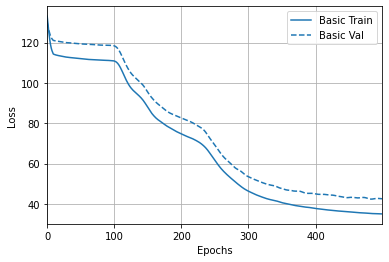

In [20]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric='loss')

In [21]:
test_labels = pd.to_numeric(test_labels, errors='coerce',downcast='float')

In [22]:
loss, root_mean_squared_error, mae, mse = model.evaluate(normed_train_data,train_labels, verbose=2)

300/300 - 0s - loss: 35.8205 - root_mean_squared_error: 35.8207 - mae: 24.4400 - mse: 1405.7625 - 386ms/epoch - 1ms/step


300/300 [==============================] - 0s 746us/step


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

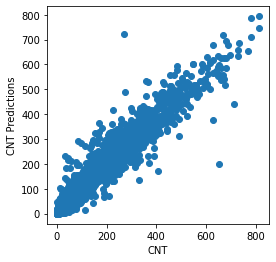

In [35]:
test_predictions = model.predict(normed_test_data).flatten()
train_predictions = model.predict(normed_train_data).flatten()


a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)

plt.xlabel("CNT")
plt.ylabel("CNT Predictions")
plt.plot

In [36]:
train_predictions[0:10]

array([131.63535 ,  10.423729, 294.03177 ,  80.54682 , 106.66307 ,
       136.65318 , 357.77496 , 109.178795, 116.434395,  53.899837],
      dtype=float32)

Poninendo los resultados en el csv de test

In [37]:
dataset_test = pd.read_excel('bike_test.xlsx')

In [38]:
dataset_test['day'] = pd.DatetimeIndex(dataset_test['dteday']).day
dataset_test['month'] = pd.DatetimeIndex(dataset_test['dteday']).month
dataset_test['year'] = pd.DatetimeIndex(dataset_test['dteday']).year
original_test_dataset_instant  = dataset_test.pop('instant')
dataset_test.drop(columns = ['dteday', 'mnth'],inplace=True)

dataset_test.tail()

,season,yr,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,day,month,year
5375,1,1,19,0,1,1,2,0.26,0.2576,0.60,0.1642,31,12,2012
5376,1,1,20,0,1,1,2,0.26,0.2576,0.60,0.1642,31,12,2012
5377,1,1,21,0,1,1,1,0.26,0.2576,0.60,0.1642,31,12,2012
5378,1,1,22,0,1,1,1,0.26,0.2727,0.56,0.1343,31,12,2012
5379,1,1,23,0,1,1,1,0.26,0.2727,0.65,0.1343,31,12,2012


In [39]:
dataset_test_normed = norm(dataset_test)
dataset_test_normed.head(3)

,season,yr,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,day,month,year
0,-0.189523,1.61253,-1.102137,-0.172691,-1.508424,-1.478746,-0.672586,0.284623,0.297653,0.273062,-0.846909,0.525493,-0.152044,1.61253
1,-0.189523,1.61253,-0.957249,-0.172691,-1.508424,-1.478746,-0.672586,0.178592,0.208005,0.472254,-0.728461,0.525493,-0.152044,1.61253
2,-0.189523,1.61253,-0.812361,-0.172691,-1.508424,-1.478746,-0.672586,0.178592,0.208005,0.024072,-0.491564,0.525493,-0.152044,1.61253


In [40]:
dataset_test_predictions = model.predict(dataset_test_normed).flatten()

169/169 [==============================] - 0s 679us/step


In [41]:
dataset_test_predictions = dataset_test_predictions.round(decimals=0)

In [42]:
def noNegatives(x):
  if x<0:
   return 0
  else:
   return x

In [43]:
# sumamos las predicciones a la tabla del dataset de test para tenerlo completo
dataset_test_complete = dataset_test

dataset_test_complete['pred'] = dataset_test_predictions.reshape(-1,1)

dataset_test_complete['pred'].apply(lambda x : noNegatives(x))

dataset_test_complete

,season,yr,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,day,month,year,pred
0,2,1,4,0,0,0,1,0.52,0.5000,0.68,0.0896,20,5,2012,41.0
1,2,1,5,0,0,0,1,0.50,0.4848,0.72,0.1045,20,5,2012,24.0
2,2,1,6,0,0,0,1,0.50,0.4848,0.63,0.1343,20,5,2012,33.0
3,2,1,7,0,0,0,1,0.52,0.5000,0.68,0.1940,20,5,2012,80.0
4,2,1,8,0,0,0,1,0.56,0.5303,0.56,0.1642,20,5,2012,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,1,1,19,0,1,1,2,0.26,0.2576,0.60,0.1642,31,12,2012,150.0
5376,1,1,20,0,1,1,2,0.26,0.2576,0.60,0.1642,31,12,2012,108.0
5377,1,1,21,0,1,1,1,0.26,0.2576,0.60,0.1642,31,12,2012,90.0
5378,1,1,22,0,1,1,1,0.26,0.2727,0.56,0.1343,31,12,2012,63.0


Cargar un csv con las predicciones del cnt de bike_test

In [44]:
cnt_pred = dataset_test_complete['pred']
cnt_pred.to_csv('Wolfgang93.csv',index=False)